In [1]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

In [2]:
import pandas as pd
df_train = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H_2024_Task3_Training_1800.csv')
df_dev = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H_2024_Task3_Validation_600_codalab.csv')
df_test = pd.read_csv('/content/drive/MyDrive/SMM4H 2024/SMM4H_Task3_testposts_decoy_keywords.csv')

In [3]:
df_train = df_train[:1800]
df_train = df_train.iloc[:, :4]
df_train['Classification'] = df_train['Classification'].astype(int)
df_dev['Classification']   =   df_dev['Classification'].astype(int)

In [4]:
df_train

,id,keyword,text,Classification
0,3u2w5k,run,"21/m. I want to experience young love, but I'v...",0
1,3xbury,outside,Having issues talking to a girl whom I enjoyed...,0
2,3y743u,"run, swim, climb",Need some advice for free social activities. I...,0
3,43bvs7,walk,I spoke to her today.. A few weeks ago I met ...,0
4,442ap2,outside,"How to get over Social Anxiety?. Hello, The ot...",0
...,...,...,...,...
1795,gqzye9,"pool, beach, pool",Social Anxiety: The Essentials. After looking...,3
1796,env299,"outside , outdoors",Eye contact. Being in public. I can't do it. ...,3
1797,e9bnr1s,Jogging,"If you look for the light, you will find it. I...",3
1798,qrmhbe,"walk, swimming, pool","I feel like my SA is ruining my life. Hi, I h...",3


In [5]:
df_dev

,id,keyword,text,Classification
0,fc6l72u,cruise,(1) I had SA but managed to practically eradic...,0
1,8eijpy,"runners, run , run","Anyone looking for a friend? Real friend, beh...",0
2,didnpbe,"running , golf","Breathe, darling. The purpose of dating is to...",0
3,dxe6gbb,sea,I've been overweight since 2nd grade and it a...,0
4,f5jqgbz,waves,I need this terribly. I’ve been in negative w...,0
...,...,...,...,...
595,edvs552,walk,The thought of applying for a job terrified m...,2
596,ee31pf,outside,No one will ever love me because I don't have...,2
597,eei3pz3,"outside, walk","5 or 7, I never shit outside of my house. Once...",2
598,eek8bpk,outside,"Yes, I hate eating in front of anyone I don’t...",2


In [6]:
df_test

,id,keyword,text
0,inmdrd,"outside, camp, camping","Venting about friend problems. Okay, so years ..."
1,rav4bw,"walk, outside, Park",I can’t live with the mind I was given.. Every...
2,e03jwjy,"climb, tree, beach, wildlife",The best guy at this summer job I quit was an ...
3,khd8q1,"walk, walk, jog",I think ive had SAD all my life and idk how to...
4,q9uxky,mountains,Part of me wants to live in a cottage somewhe...
...,...,...,...
1195,dt18716,"soccer, basketball, baseball, basketball, bask...",Just do it. Sports don’t require a lot of soc...
1196,nilic6,outside,I (23M) feel like going outside but i don't kn...
1197,cz24q1,"outside, walk, beach",hanging out with stoners how can you have fun...
1198,e9xd0uy,surf,"I love memes, but this sub is not the place f..."


In [7]:
print(len(df_train))
print(len(df_dev))
print(len(df_test))

1800
600
1200


In [8]:
import re
import pandas as pd
def preprocess_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = text.lower()
    text = re.sub(r'[@#]\w+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
df_train['text'] = df_train['text'].apply(preprocess_text)
df_dev['text'] = df_dev['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [9]:
!pip install transformers seqeval torch tqdm accelerate sentencepiece datasets

In [10]:
"""df_merged = pd.concat([df_train, df_dev]).sort_index(kind='merge').reset_index(drop=True)
df_merged"""

"df_merged = pd.concat([df_train, df_dev]).sort_index(kind='merge').reset_index(drop=True)\ndf_merged"

In [11]:
print(df_train['Classification'].value_counts())
print(df_dev['Classification'].value_counts())

Classification
0    1131
2     395
1     160
3     114
Name: count, dtype: int64
Classification
0    377
2    131
1     54
3     38
Name: count, dtype: int64


In [12]:
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy, TrainerCallback
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from accelerate import Accelerator
import numpy as np
import torch
import os
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)
class SaveModelCallback(TrainerCallback):
    def __init__(self, output_dir):
        self.output_dir = output_dir
    def on_epoch_end(self, args, state, control, **kwargs):
        output_dir = os.path.join(self.output_dir, f"epoch_bartlarge_X_{state.epoch}")
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        tokenizer.save_pretrained(output_dir)
texts = df_train['text'].tolist()
labels = df_train['Classification'].tolist()
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large', num_labels=4) # Adjust num_labels as per your requirement
train_dataset = TextDataset(tokenizer, texts, labels)
training_args = TrainingArguments(
    output_dir='./results_temp',
    num_train_epochs=50,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=0,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    evaluation_strategy=IntervalStrategy.NO,
    save_strategy=IntervalStrategy.NO,
    load_best_model_at_end=False,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    callbacks=[SaveModelCallback(output_dir='./model_saves')]
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWar

Step,Training Loss
100,1.022300
200,0.841000
300,0.715400
400,0.581000
500,0.584500
600,0.451900
700,0.441200
800,0.298000
900,0.391000
1000,0.247300


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

TrainOutput(global_step=4500, training_loss=0.15587372135091573, metrics={'train_runtime': 4132.9416, 'train_samples_per_second': 8.711, 'train_steps_per_second': 1.089, 'total_flos': 3.9124413628416e+16, 'train_loss': 0.15587372135091573, 'epoch': 20.0})

In [13]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
class TextDataset(Dataset):
    def __init__(self, tokenizer, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=512)
        self.labels = labels if labels is not None else [0] * len(texts)
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings['input_ids'])

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3'}. The number of labels wil be overwritten to 4.


Evaluating:   0%|          | 0/150 [00:00<?, ?it/s]

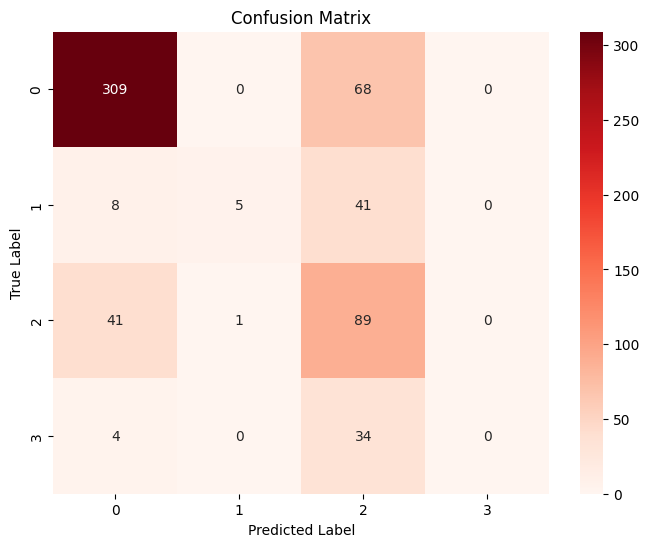

Accuracy: 0.6716666666666666
F1 Score (Class 1): 0.37332250416578133
Recall (Macro): 0.39790263819613647
Precision (Macro): 0.5176362958023751


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_1.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy(), probabilities[:,2].cpu().numpy(), probabilities[:,3].cpu().numpy()))
df_predictions_1 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight', 'prediction_2_weight', 'prediction_3_weight'])        #THIS
df_merged_1 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_1['Classification']                                                                                                   #THIS
predicted_labels = df_merged_1['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, average='macro')
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_1.to_csv('BartLargeX_task3_predictions_002_epoch_1.csv', index=False)                     #XXX                           #THIS

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_1.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy(), probabilities[:,2].cpu().numpy(), probabilities[:,3].cpu().numpy()))
df_predictions_1 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight', 'prediction_2_weight', 'prediction_3_weight'])        #THIS
df_merged_1 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_1['Classification']                                                                                                   #THIS
predicted_labels = df_merged_1['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, average='macro')
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_1.to_csv('BartLargeX_task3_predictions_002_epoch_1.csv', index=False)                     #XXX                           #THIS

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_1.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy(), probabilities[:,2].cpu().numpy(), probabilities[:,3].cpu().numpy()))
df_predictions_1 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight', 'prediction_2_weight', 'prediction_3_weight'])        #THIS
df_merged_1 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_1['Classification']                                                                                                   #THIS
predicted_labels = df_merged_1['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, average='macro')
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_1.to_csv('BartLargeX_task3_predictions_002_epoch_1.csv', index=False)                     #XXX                           #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1', '2': 'LABEL_2', '3': 'LABEL_3'}. The number of labels wil be overwritten to 4.


Evaluating:   0%|          | 0/150 [00:00<?, ?it/s]

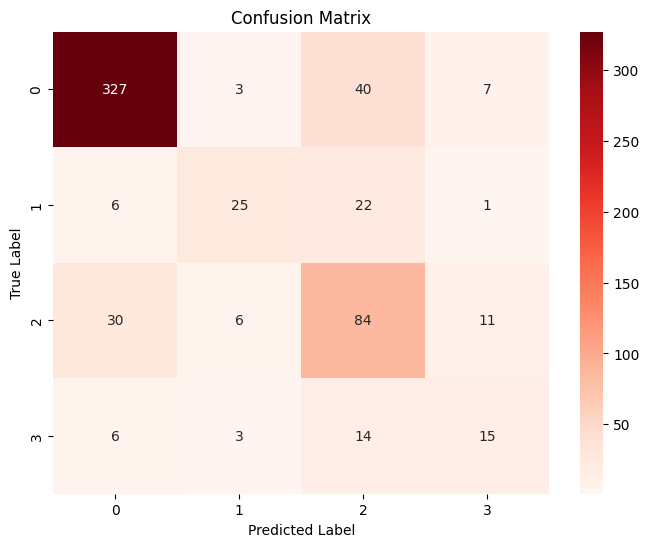

Accuracy: 0.7516666666666667
F1 Score (Class 1): 0.60502810174081
Recall (Macro): 0.5915737961047669
Precision (Macro): 0.6320077520131322


In [18]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_20.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy(), probabilities[:,2].cpu().numpy(), probabilities[:,3].cpu().numpy()))
df_predictions_20 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight', 'prediction_2_weight', 'prediction_3_weight'])        #THIS
df_merged_20 = pd.concat([df_dev, df_predictions_20], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_20['Classification']                                                                                                   #THIS
predicted_labels = df_merged_20['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, average='macro')
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_20.to_csv('BartLargeX_task3_predictions_002_epoch_20.csv', index=False)                     #XXX                           #THIS

In [ ]:
xxx

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/550 [00:00<?, ?it/s]

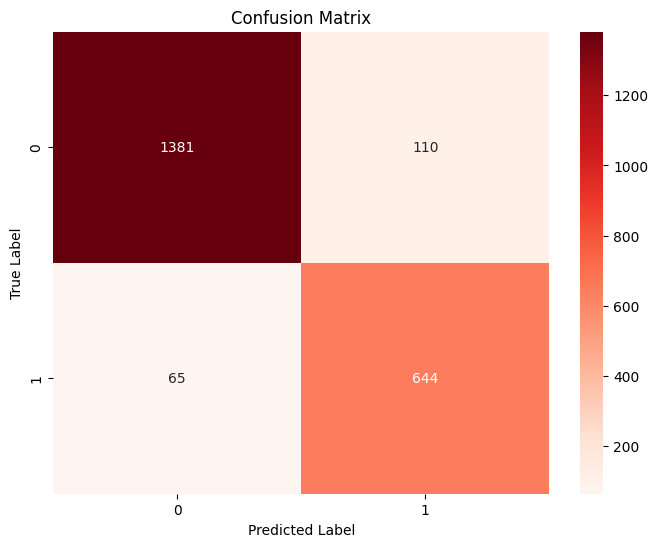

Accuracy: 0.9204545454545454
F1 Score (Class 1): 0.8803827751196173
Recall (Macro): 0.9172727952103784
Precision (Macro): 0.9045799076203999


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_2.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_2 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_2 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_2['label']                                                                                                   #THIS
predicted_labels = df_merged_2['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_2.to_csv('BartLargeA_task6_predictions_002_epoch_2.csv', index=False)                     #XXX                           #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/550 [00:00<?, ?it/s]

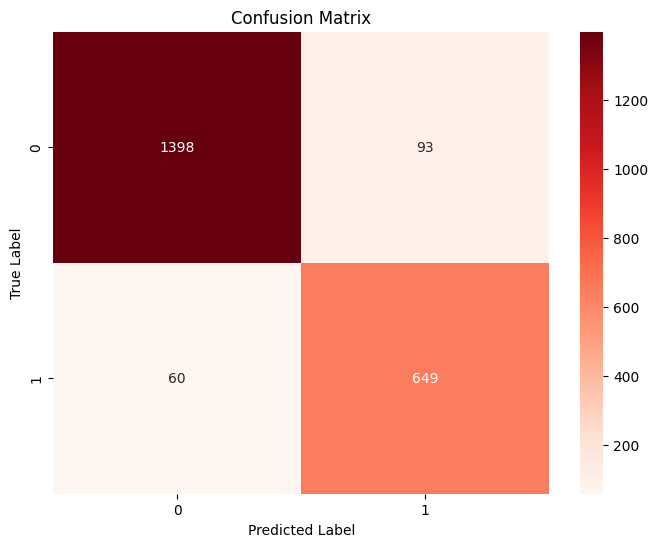

Accuracy: 0.9304545454545454
F1 Score (Class 1): 0.8945554789800139
Recall (Macro): 0.926499760197291
Precision (Macro): 0.9167554047008973


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_3.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_3 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_3 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_3['label']                                                                                                   #THIS
predicted_labels = df_merged_3['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_3.to_csv('BartLargeA_task6_predictions_002_epoch_3.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/550 [00:00<?, ?it/s]

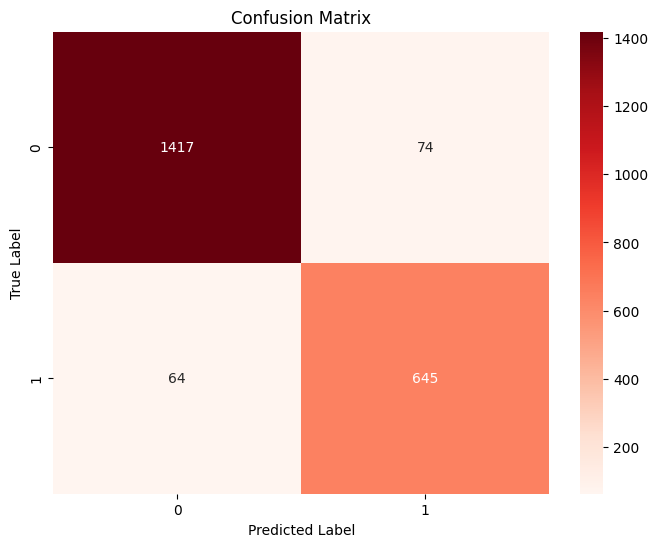

Accuracy: 0.9372727272727273
F1 Score (Class 1): 0.9033613445378152
Recall (Macro): 0.9300504484357959
Precision (Macro): 0.9269326161044065


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_4.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_4 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_4 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_4['label']                                                                                                   #THIS
predicted_labels = df_merged_4['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_4.to_csv('BartLargeA_task6_predictions_002_epoch_4.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/550 [00:00<?, ?it/s]

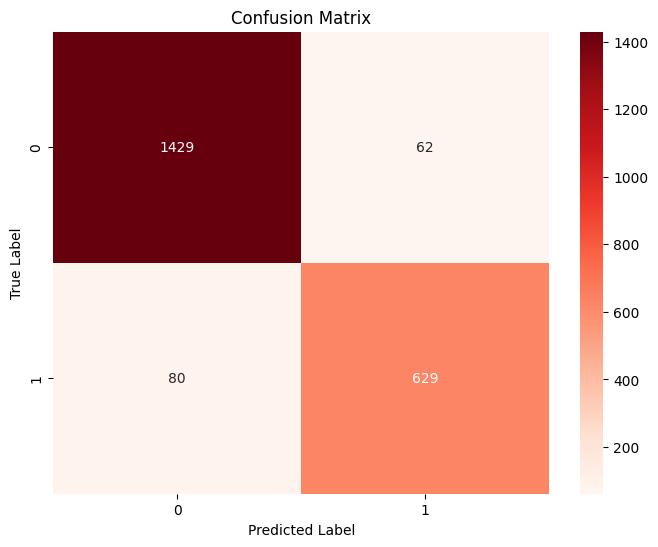

Accuracy: 0.9354545454545454
F1 Score (Class 1): 0.8985714285714285
Recall (Macro): 0.9227910954206668
Precision (Macro): 0.9286298609692545


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_5.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_5 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_5 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_5['label']                                                                                                   #THIS
predicted_labels = df_merged_5['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_5.to_csv('BartLargeA_task6_predictions_002_epoch_5.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/550 [00:00<?, ?it/s]

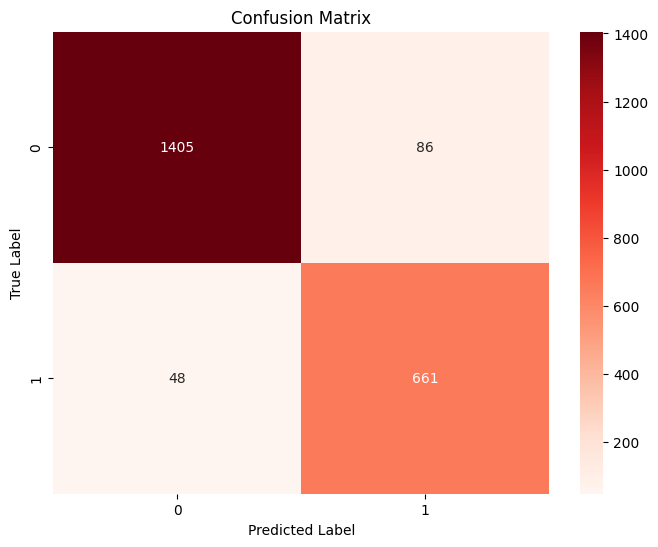

Accuracy: 0.9390909090909091
F1 Score (Class 1): 0.907967032967033
Recall (Macro): 0.9373098014509247
Precision (Macro): 0.9259188624191651


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge__6.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_6 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_6 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_6['label']                                                                                                   #THIS
predicted_labels = df_merged_6['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_6.to_csv('BartLargeA_task6_predictions_002_epoch_6.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/550 [00:00<?, ?it/s]

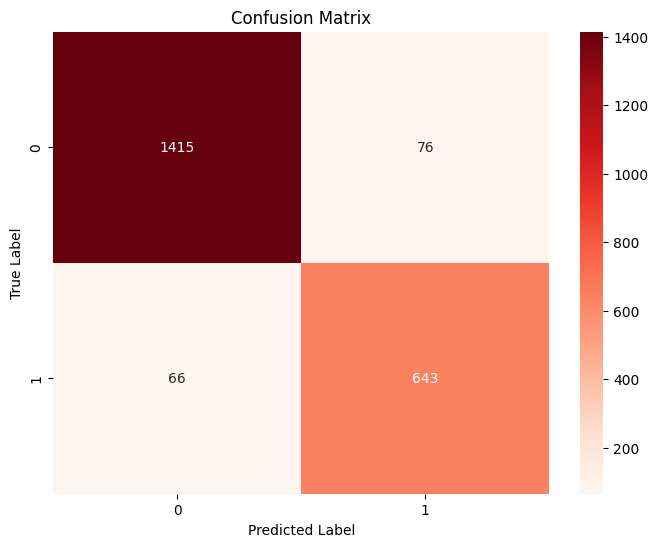

Accuracy: 0.9354545454545454
F1 Score (Class 1): 0.900560224089636
Recall (Macro): 0.9279693203887169
Precision (Macro): 0.9248665760739416


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_7.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_7 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_7 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_7['label']                                                                                                   #THIS
predicted_labels = df_merged_7['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_7.to_csv('BartLargeA_task6_predictions_002_epoch_7.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/550 [00:00<?, ?it/s]

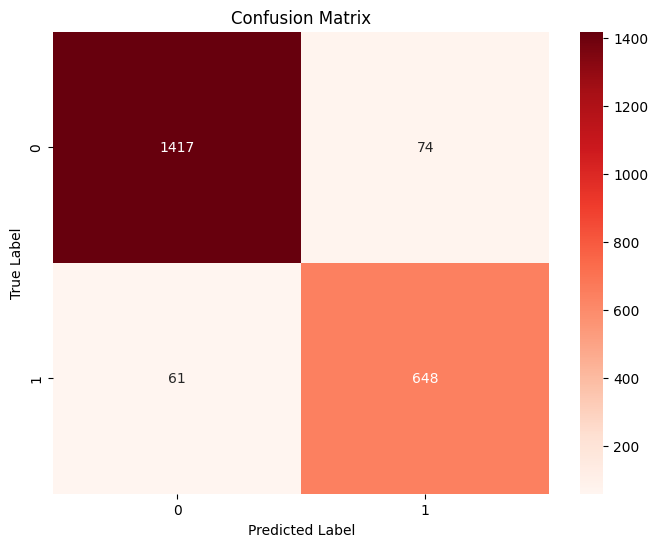

Accuracy: 0.9386363636363636
F1 Score (Class 1): 0.9056603773584906
Recall (Macro): 0.9321661042891103
Precision (Macro): 0.928117468016598


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_8.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_8 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_8 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_8['label']                                                                                                   #THIS
predicted_labels = df_merged_8['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_8.to_csv('BartLargeA_task6_predictions_002_epoch_8.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/550 [00:00<?, ?it/s]

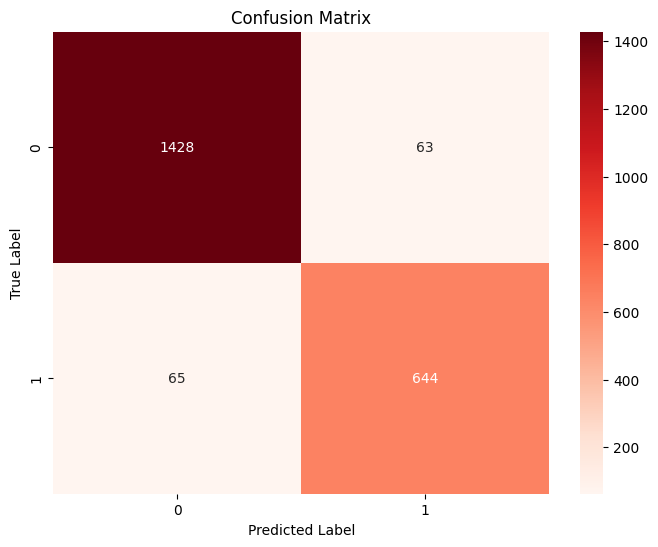

Accuracy: 0.9418181818181818
F1 Score (Class 1): 0.9096045197740112
Recall (Macro): 0.9330340292814716
Precision (Macro): 0.9336772927125265


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_9.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_9 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_9 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_9['label']                                                                                                   #THIS
predicted_labels = df_merged_9['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_9.to_csv('BartLargeA_task6_predictions_002_epoch_9.csv', index=False)                     #XXX                          #THIS #THIS

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


Evaluating:   0%|          | 0/550 [00:00<?, ?it/s]

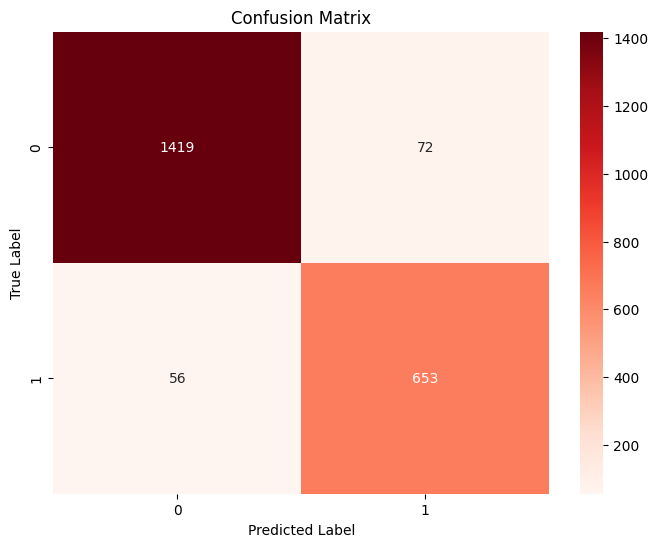

Accuracy: 0.9418181818181818
F1 Score (Class 1): 0.9107391910739191
Recall (Macro): 0.9363628881895038
Precision (Macro): 0.9313617767387493


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large')
model = AutoModelForSequenceClassification.from_pretrained('/content/model_saves/epoch_bartlarge_X_10.0')                #XXX       #THIS
model = model.to('cuda')
dev_texts = df_dev['text'].tolist()                                                                                   #XXX
dev_dataset = TextDataset(tokenizer, dev_texts)
dev_loader = DataLoader(dev_dataset, batch_size=4, shuffle=False)
predictions = []
for batch in tqdm(dev_loader, desc="Evaluating"):
    inputs = {k: v.to(model.device) for k, v in batch.items() if k != 'labels'}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    pred_labels = logits.argmax(1)
    predictions.extend(zip(pred_labels.cpu().numpy(), probabilities[:,0].cpu().numpy(), probabilities[:,1].cpu().numpy()))
df_predictions_10 = pd.DataFrame(predictions, columns=['predicted_label', 'prediction_0_weight', 'prediction_1_weight'])        #THIS
df_merged_10 = pd.concat([df_dev, df_predictions_1], axis=1)                                      #XXX                        #THIS #THIS
true_labels = df_merged_10['label']                                                                                                   #THIS
predicted_labels = df_merged_10['predicted_label']                                                                                    #THIS
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
f1_class_1 = f1_score(true_labels, predicted_labels, pos_label=1)
recall_macro = recall_score(true_labels, predicted_labels, average='macro')
precision_macro = precision_score(true_labels, predicted_labels, average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score (Class 1): {f1_class_1}")
print(f"Recall (Macro): {recall_macro}")
print(f"Precision (Macro): {precision_macro}")
df_merged_10.to_csv('BartLargeA_task6_predictions_002_epoch_10.csv', index=False)                     #XXX                          #THIS #THIS

In [ ]:
!pip install transformers huggingface_hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfApi, create_repo, upload_folder
hf_username = "1024m"  # Replace with your actual username
repo_name = "SMM4H-Task6-BartL-A10"  # Name of the new repository
api = HfApi()
if not api.repo_exists(f"{hf_username}/{repo_name}"):
    create_repo(repo_name,private=False)
model_directory = '/content/model_saves/epoch_bartlarge_A_10.0'
upload_folder(
    folder_path=model_directory,
    repo_id=f"{hf_username}/{repo_name}"
)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/1024m/SMM4H-Task6-BartL-A10/commit/67c3c193cfc695f39b78fcbfe343c982f4e723c1', commit_message='Upload folder using huggingface_hub', commit_description='', oid='67c3c193cfc695f39b78fcbfe343c982f4e723c1', pr_url=None, pr_revision=None, pr_num=None)